# Simple presidential poll aggregator & election forecaster

This simulation borrows most of the code from [Drew Linzer's](https://twitter.com/drewlinzer) simple 2020 simulation. I then updated it so I could backtest on previous election and polling data. Here are some takeaways: 

* Overall, it does pretty well in recent elections, although it has roughly twice the average election night error in electoral votes as [538](https://projects.fivethirtyeight.com/checking-our-work/presidential-elections/). 
* Running historic predictions using August polling data introduces additional error. This suggest that predicting how the polls might change up to an election could be valuable, although this is not an easy task. This is what adds so much complexity to the 538/Economist models.
* Maybe just [leaving uncertainty](https://twitter.com/DrewLinzer/status/1290812692513529857) in the model and not trying to predict polling shifts is the best approach.

The original code is described on twitter [here](https://twitter.com/DrewLinzer/status/1293216060456329216), available on Google colab [here](https://colab.research.google.com/drive/1iFcc44FMrKm4r_p83l2zVDxLLkh9K8KZ?usp=sharing), and also included in this repo (`Simple_presidential_poll_aggregator_&_election_forecaster.ipynb`).  

**Here's the original description of how the model works:**

A basic model for aggregating presidential polls and forecasting the 2020 presidential election by simulation. This model is over-simplified by design to illustrate the core features of a simulation-based forecasting model, and eliminate as much complexity -- and analyst input -- as possible. The model relies on polls only. It is little more than a poll aggregator with some options for expressing uncertainty in the polls.

The model produces three sets of estimates:

1. Simulated distributions of state popular vote outcomes that are consistent with the recent polling data
1. A simulated distribution of electoral vote outcomes that are consistent with the recent polling data
1. Simulated probabilities of Biden/Trump winning each state and the electoral vote

The algorithm:

1. Get state and national level polling data. Convert head-to-head poll results to their major-party vote shares. This excludes third party candidates and assumes undecideds "break" in proportion to the poll results. A poll showing Biden 45%-Trump 40% is treated as Biden 45/85 = 53% and Trump 40/85 = 47%.
1. If a state has been polled in the past two months, use the average of the state's polls as our best guess about the election outcome. There are no adjustments for house effects, mode effects, historical factors, "reversion" to a closer outcome by Election Day, etc. Polls are treated has having "happened" on the last day they were conducting interviews.
1. If a state has **not** been polled in the past two months, use as our best guess about the election outcome the state's 2016 election result plus the national shift to Biden based on national polls in 2020 (uniform swing).
1. Assume that the state vote estimates have an uncertainty range of plus-minus 10% regardless of how much polling has happened in the state. This is based on research in [this paper](https://votamatic.org/wp-content/uploads/2015/08/2015LauderdaleLinzerIJF.pdf). It can be adjusted with the "state_uncertainty_sd" parameter.
1. Assume that all of the states could have an additional national-level "correlated" error due to all polling being systematically biased by a certain amount. This is a national bias, not regional, clustered, etc. If the state polls are unbiased, on average, then the national error is zero. Assume the national bias will probably not exceed 6% in either direction. This can be adjusted with the "national_uncertainty_sd" parameter.
1. Simulate one national election:
  1. Sample an election result (Biden vote share) for each state from a normal distribution, with mean equal to the state's vote estimate, and standard deviation of 5%, then add a constant national error to every state with mean 0 and standard deviation of 3% in each simulation.
  1. The candidate who gets over 50% of the major-party vote in a state wins all of that state's electoral votes. (No adjustment for Maine/Nebraska.)
  1. The candidate who wins 270 electoral votes wins the election.
1. Repeat the simulation 10,000 times to get the chance that Biden/Trump will win the election.


In [147]:
import os
import datetime

import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
#import statsmodels.api as sm
#from scipy import stats
import matplotlib
from matplotlib import pyplot as plt

## Load polling data, presidential data, state metadata

- Convert Dem and Rep polls and votes to major-party vote share

In [116]:
pres_df = pd.read_csv(
    os.path.join(os.getcwd(), 'data', 'federal-elections', 'presidential_results_76_16.csv')
)

# Create a national dem_margin column for use in national_swing later
national_df = pres_df.copy()
national_df['dem_votes'] = national_df['dem']*national_df['total_votes']
national_df['rep_votes'] = national_df['rep']*national_df['total_votes']
national_df = national_df.groupby(by='year').agg({'dem_votes': 'sum', 'rep_votes': 'sum'})
national_df['dem'] = (national_df['dem_votes']) / \
    (national_df['dem_votes'] + national_df['rep_votes'])

# Convert Dem and Rep votes to major-party vote share
pres_df['both'] = pres_df['dem'] + pres_df['rep']
pres_df['dem'] = pres_df['dem']/pres_df['both']
pres_df['rep'] = pres_df['dem']/pres_df['both']

pres_df.head()

,year,state,total_votes,dem,rep,other,both
0,1976,AK,123574,0.381082,0.407323,0.054906,0.935577
1,1976,AL,1182850,0.566667,0.576220,0.016318,0.983421
2,1976,AR,767535,0.650489,0.651361,0.001339,0.998661
3,1976,AZ,742719,0.413867,0.430367,0.038309,0.961661
4,1976,CA,7803770,0.490822,0.502360,0.022969,0.977031


In [117]:
national_df.tail()

,dem_votes,rep_votes,dem
year,,,
2000,50996062.0,50456169.0,0.502661
2004,59028079.0,62028285.0,0.487608
2008,69498459.0,59948283.0,0.536888
2012,65899660.0,60932152.0,0.519583
2016,65853503.0,62984803.0,0.511133


In [118]:
state_df = pd.read_csv(
    os.path.join(os.getcwd(), 'data', 'misc', 'state_metadata.csv')
)
state_df.head()

,fips,state_abbr,state_name,pop_2018,electoral_votes_2016
0,1,AL,Alabama,4887871,9
1,2,AK,Alaska,737438,3
2,4,AZ,Arizona,7171646,11
3,5,AR,Arkansas,3013825,6
4,6,CA,California,39557045,55


In [141]:
# Historic polling data, 2008, 2012, 2016
# https://github.com/TheEconomist/us-potus-model/tree/master/data
def load_polls(params):
    dfs = []
    for (year, dem, rep) in params:
        polls_df = pd.read_csv(
            os.path.join(os.getcwd(), 'data', 'polls', 'economist', 'all_polls_{0}.csv'.format(year))
        )
        polls_df['state'] = polls_df['state'].replace({'--': 'national'})
        polls_df.rename(columns={dem: 'dem', rep: 'rep', 'end.date': 'date'}, inplace=True)
        polls_df['year'] = year
        polls_df.replace({'20020': '2020'}, inplace=True, regex=True) #Deal with typo
        polls_df['date'] = pd.to_datetime(polls_df['date'])
        polls_df = polls_df[['state', 'year', 'date', 'dem', 'rep']]
        dfs.append(polls_df)

    polls_df = pd.concat(dfs)
    # Calculate the two party polling margin
    polls_df['both'] = polls_df['dem'] + polls_df['rep']
    polls_df['dem'] = polls_df['dem']/polls_df['both']
    polls_df['rep'] = polls_df['rep']/polls_df['both']
    del polls_df['both']
    
    return polls_df

def prepare_polls(year, start_date, end_date, pres_df, polls_df, national_df):
    '''Prepares polls for use with the simulation, filling in missing
    polls with the national swing since last election.
    This will work for 2008-2016 with the polling data you have.'''

    # Calculate mean polls over the past two months
    # Consider running regression through polls instead, to pick up trend.
    polls_df = polls_df[polls_df['year'] == year]
    polls_df = polls_df[
        (polls_df.date >= start_date) &
        (polls_df.date <= end_date)
    ]
    mean_polls = polls_df.groupby(by=['state']).agg({'dem':'mean'}) #'rep': 'mean', rep polls not used
    
    # Use exponential decay on polls, rather than hard cutoff.
    # Actually performs better on both August nowcast, and election night,
    # but would be susceptible to outlier polls in infrequently polled states.
    # mean_polls = exponential_decay(year, polls_df)
    print('{0} States with polls: {1}'.format(year, len(mean_polls)))

    # Fill in states with missing polls using national swing
    # You can also do this for e.g. the Senate using the generic ballot and the Senate margin 
    # Nope, that won't work, because the generic ballot is at national level while senate is state by state. 
    # Maybe just do change in generic ballot? but you only have 2017 + generic.
    # I guess you could just use this national swing value for Senate seats as well.
    national_swing = mean_polls['dem']['national'] - national_df.loc[year-4, 'dem']
    print('National Democratic Swing from {0} to {1}:'.format(year-4, year), national_swing)
    national_swing_df = pres_df[pres_df['year'] == year-4].copy()
    national_swing_df['dem'] = national_swing_df['dem'] + national_swing
    national_swing_df = national_swing_df[['state', 'dem']].set_index('state')
    national_swing_df = national_swing_df[~national_swing_df.index.isin(mean_polls.index)]
    
    # Trying to just default to previous result
    # Performs about same in election night forecast,
    # but does worse on August nowcast.
    # past_election = pres_df[pres_df['year'] == year-4].copy()
    # past_election = past_election[['state', 'dem']].set_index('state')
    # past_election = past_election[~past_election.index.isin(mean_polls.index)]
    
    mean_polls = pd.concat([mean_polls, national_swing_df])
    mean_polls.drop(labels='national', inplace=True) #Remove national polls now    
    return mean_polls

def predict_polls(year, today, election_date, pres_df, polls_df, national_df):
    '''TODO: Runs a regression through past two elections and current polling data
    to predict the election results. Then sample from these values. Maybe this could
    account for a tightening race?'''
    
    # Calculate mean polls over the past two months
    polls_df = polls_df[polls_df['year'] == year]
    mean_polls = polls_df.groupby(by=['state']).agg({'dem':'mean'}) #'rep': 'mean', rep polls not used
    
    # Fill in states with missing polls using national swing
    national_swing = mean_polls['dem']['national'] - national_df.loc[year-4, 'dem']
    #print('National Democratic Swing from {0} election to {1} polls:'.format(year-4, year), national_swing)
    past_election = pres_df[pres_df['year'] == year-4].copy()
    past_election['dem'] = past_election['dem'] + national_swing
    past_election = past_election[['state', 'dem']].set_index('state')
    past_election = past_election[~past_election.index.isin(mean_polls.index)]
    
    for state in polls_df['state']:
        reg_df = polls_df['state']
        #ordinary least squares, predict election date
        #return estimates, then concat with filled in missing polls
        #but this approach could be problematic too, because you could 
        #get some crazy predictions with low numbers of polls.
        
def exponential_decay(year, polls_df):
    # More or less, all this does is weight the values towards
    # more recent polls, with a half life of 30d.
    # Does perform better historically in both nowcast and forcast,
    # but probably fragile to outlier polls in rarely polled states.
    # https://en.wikipedia.org/wiki/Exponential_decay
    election_dates = {
        2008: pd.to_datetime('2008-11-4'),
        2012: pd.to_datetime('2012-11-6'),
        2016: pd.to_datetime('2016-11-8'),
        2020: pd.to_datetime('2020-8-17')
    }
    polls_df = polls_df[polls_df['year'] == year].copy()
    polls_df['days_away'] = (election_dates[year] - polls_df['date']).dt.days
    half_life = 30 #In days
    polls_df['weight'] = 2**(-polls_df['days_away']/half_life) #2^(-t/half_life)
    # Note, if there's only one poll from months ago, this will still give it full value
    # because the only weight will be the small one from months ago.
    mean_polls = polls_df.groupby(by=['state']).apply(lambda x: np.average(x.dem, weights=x.weight))
    mean_polls = mean_polls.to_frame(name='dem')
    return mean_polls

# Other options for weighting past elections and polls
# What about a 75/25 balance between the two?

In [ ]:
# Current 2020 polls here:
poll_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQ56fySJKLL18Lipu1_i3ID9JE06voJEz2EXm6JW4Vh11zmndyTwejMavuNntzIWLY0RyhA1UsVEen0/pub?gid=0&single=true&output=csv'
out_path = os.path.join(os.getcwd(), 'data', 'polls', 'economist', 'all_polls_2020.csv')
polls = pd.read_csv(poll_url)
polls.to_csv(out_path, index=False)
archive_name = 'all_polls_{0}.csv'.format(datetime.date.today().isoformat())
polls.to_csv(os.path.join(os.getcwd(), 'data', 'archive', archive_name))
print('Total current polls: ', len(polls))

In [121]:
# Load all polls initially, filter later
params = [
    (2008, 'obama', 'mccain'),
    (2012, 'obama', 'romney'),
    (2016, 'clinton', 'trump'),
    (2020, 'biden', 'trump')
]
polls_df = load_polls(params)
polls_df

,state,year,date,dem,rep
0,AK,2008,2008-03-06,0.472527,0.527473
1,AK,2008,2008-05-17,0.450549,0.549451
2,AK,2008,2008-06-18,0.476744,0.523256
3,AK,2008,2008-07-16,0.445652,0.554348
4,AK,2008,2008-07-21,0.470588,0.529412
...,...,...,...,...,...
723,national,2020,2020-02-09,0.537634,0.462366
724,national,2020,2020-01-22,0.549451,0.450549
725,national,2020,2020-01-19,0.546392,0.453608
726,national,2020,2020-01-01,0.539326,0.460674


## Simulate election outcome

Increasing the amount of uncertainty in the state poll average and/or the national polling error shifts the probability of winning towards 0.5.

In [122]:
electoral_votes = pd.DataFrame.from_dict({'AL': 9, 'AK': 3, 'AZ': 11, 'AR': 6, 'CA': 55, 'CO': 9,
    'CT': 7, 'DE': 3, 'FL': 29, 'GA': 16, 'HI': 4, 'ID': 4,'IL': 20, 'IN': 11, 'IA': 6, 'KS': 6, 
    'KY': 8, 'LA': 8, 'ME': 4, 'MD': 10, 'MA': 11, 'MI': 16, 'MN': 10, 'MS': 6, 'MO': 10, 'MT': 3, 
    'NE': 5, 'NV': 6, 'NH': 4, 'NJ': 14, 'NM': 5, 'NY': 29, 'NC': 15, 'ND': 3, 'OH': 18, 'OK': 7,
    'OR': 7, 'PA': 20, 'RI': 4, 'SC': 9, 'SD': 3, 'TN': 11, 'TX': 38, 'UT': 6, 'VT': 3, 'VA': 13, 
    'WA': 12, 'WV': 5,'WI': 10, 'WY': 3, 'DC': 3},
    orient='index', columns = ['EV'])

# https://www.archives.gov/electoral-college/2008
electoral_votes_2008 = pd.DataFrame(data=[('AL',9), ('AK',3), ('AZ',10), ('AR',6), ('CA',55), 
    ('CO',9), ('CT',7), ('DE',3), ('DC',3), ('FL',27), ('GA',15), ('HI',4), ('ID',4), 
    ('IL',21), ('IN',11), ('IA',7), ('KS',6), ('KY',8), ('LA',9), ('ME',4), ('MD',10), 
    ('MA',12), ('MI',17), ('MN',10), ('MS',6), ('MO',11), ('MT',3), ('NE',5), ('NV',5), 
    ('NH',4), ('NJ',15), ('NM',5), ('NY',31), ('NC',15), ('ND',3), ('OH',20), ('OK',7), 
    ('OR',7), ('PA',21), ('RI',4), ('SC',8), ('SD',3), ('TN',11), ('TX',34), ('UT',5), 
    ('VT',3), ('VA',13), ('WA',11), ('WV',5), ('WI',10), ('WY',3)], columns=['state','EV'])
electoral_votes_2008.set_index('state', inplace=True)


In [123]:
def run_simulation(n, year, state_uncertainty_sd, national_uncertainty_sd, state_mean, electoral_votes):
    '''Can be used to simulate 2008, 2012, 2016, 2020 elections with polling data and electoral
    college data I have. Just make sure you use the correct state electoral college votes for 2008.'''

    dem_state_wins = pd.Series(0, index = state_mean.index)
    dem_state_votes = pd.DataFrame()
    dem_ev_sim = []
    tipping_point_states = []

    for sim in np.arange(n):
        # simulate 51 state-level election outcomes
        national_error = np.random.normal(0, national_uncertainty_sd)
        # Try using a student's T distribution here?
        # national_error = stats.t.rvs(df=4, loc=0, scale=national_uncertainty_sd)
        # 'dem_vote': stats.t.rvs(df=4, loc=state_mean.dem, scale=state_uncertainty_sd) + national_error
        one_simulation = pd.DataFrame({
            'state': state_mean.index,
            'dem_vote': np.random.normal(state_mean.dem, state_uncertainty_sd) + national_error
        }).set_index('state')

        # did Biden win each state in this simulation?
        one_simulation['dem_win'] = (one_simulation.dem_vote > 0.5)+0

        # record simulation results
        one_simulation = one_simulation.merge(electoral_votes, left_index = True, right_index = True)
        dem_state_wins = dem_state_wins + one_simulation.dem_win
        dem_state_votes = dem_state_votes.append(one_simulation.dem_vote)
        one_simulation['dem_ev'] = one_simulation.dem_win * one_simulation.EV
        dem_ev = one_simulation['dem_ev'].sum()
        dem_ev_sim = dem_ev_sim + [dem_ev]
        # Find tipping point state, sorting after vector addition above
        if dem_ev > 269:
            one_simulation = one_simulation.sort_values(by='dem_vote', ascending=False)
        else:
            # Calculate the R Winner tipping point
            one_simulation = one_simulation.sort_values(by='dem_vote', ascending=True)
        one_simulation['cumulative_votes'] = one_simulation.EV.cumsum()
        tipping_point_state = one_simulation[one_simulation['cumulative_votes'] >= 270].head(1).index[0]
        tipping_point_states.append(tipping_point_state)

    return {'dem_state_wins' : dem_state_wins, 'dem_state_votes': dem_state_votes,
       'dem_ev_sim': dem_ev_sim, 'tipping_point_states': tipping_point_states}

**Notes on tipping point calculation:**

* https://www.270towin.com/news/2020/08/01/simulator-enhancements-bellwether-tipping-point-frequencies-added_1073.html
Tipping Point: This is the state that gives the election winner 270 electoral votes, when ordering the states won from largest to smallest margin of victory.

* So this means I have to calculate the tipping point for Trump and Biden victories separately. This doesn't really make a difference in my calculations. But it might in closer elections.

* They separate ascending/descending depending on who wins on the economist also: https://github.com/TheEconomist/us-potus-model/blob/85be55ae7b0bc68cb155a9ca975e155837eb4851/scripts/model/final_2012.R#L809

In [124]:
# Simulation settings
number_of_simulations = 10000

# Uncertainty in state forecasts, around poll average
state_uncertainty_sd = 0.05

# Uncertainty in national forecasts; correlated error with mean zero
national_uncertainty_sd = 0.03

prediction_dates = [
    pd.to_datetime('today')
]

sim_results = {}
# TODO: make this a function?
for date in prediction_dates: 
    year = date.year
    start_date = date - DateOffset(months=2) #Polls from last 2 months
    end_date = date
    state_mean = prepare_polls(year, start_date, end_date, pres_df, polls_df, national_df)
    if year == 2008:
        ev = electoral_votes_2008
    else:
        ev = electoral_votes
    sim_results[year] = run_simulation(
        number_of_simulations,
        year, 
        state_uncertainty_sd, 
        national_uncertainty_sd,
        state_mean,
        ev
    )

2020 States with polls: 32
National Democratic Swing from 2016 to 2020: 0.0383763623431258


# Visualizing initial polling distribution

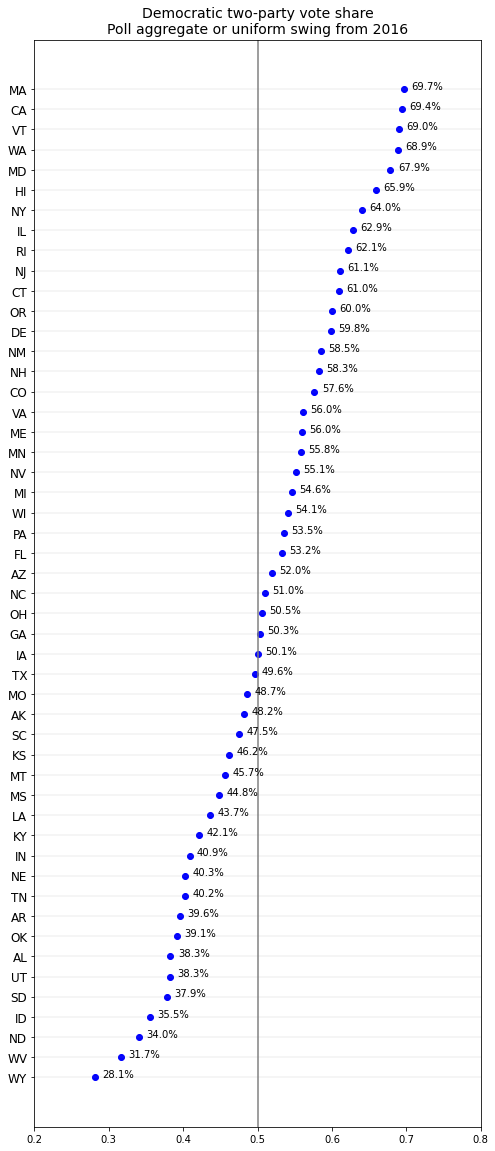

In [125]:
fig, ax = plt.subplots(figsize=(8,20))

# Don't plot DC
state_mean_sorted = (state_mean.sort_values('dem'))[:-1]

plt.xlim(0.2,0.8)
plt.title('Democratic two-party vote share\nPoll aggregate or uniform swing from 2016', fontsize = 14)
plt.yticks(np.arange(len(state_mean_sorted)), state_mean_sorted.index, fontsize = 12)
plt.axvline(0.5, color = 'gray');

plt.scatter(state_mean_sorted.dem, np.arange(len(state_mean_sorted)), color = 'blue');
for i, state in enumerate(state_mean_sorted.index):
    plt.axhline(i, color = 'gray', alpha = 0.1);
    plt.text(state_mean_sorted.dem[state] + 0.01, i, 
         '%s%%'%(100*state_mean_sorted.dem[state]).round(1));

## Visualize simulation results and chance of winning each state and nationally

- Black line: The result needed to win
- Red line: Simulation average

In [153]:
# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return idx
# # This is an estimate of the probability of an electoral tie
# kde = sm.nonparametric.KDEUnivariate(biden_ev_sim)
# kde.fit(clip=[0,538]) #kernel='gau',
# tie_prob = kde.evaluate(269)[0]
# dem_win_prob = 1 - kde.cdf[find_nearest(kde.support, 269)]
# print('Dem win probability: ', dem_win_prob)
# print('Tie probability: ', tie_prob)
# plt(kde.support, kde.evaluate(kde.support), '-b') #, label='CDF'

def plot_histogram(sim_results, year, ax=None):
    sim_results = sim_results[year]
    if not ax:
        fig, ax = plt.subplots(figsize = (10,6))
    ax.hist(sim_results['dem_ev_sim'], bins = np.arange(100, 538, 1), density = True, alpha=0.9)
    dem_ev_forecast = int(np.array(sim_results['dem_ev_sim']).mean())
    ax.set_title('Distribution of simulated Democratic electoral votes\n{0} Dem EV mean: {1}; Win probability: {2}'.format(
        year,
        dem_ev_forecast, 
        (np.array(sim_results['dem_ev_sim']) > 269).mean().round(3), fontsize = 14)
    )
    ax.axvline(269, color = 'black')
    ax.axvline(dem_ev_forecast, color = 'red')
    return ax

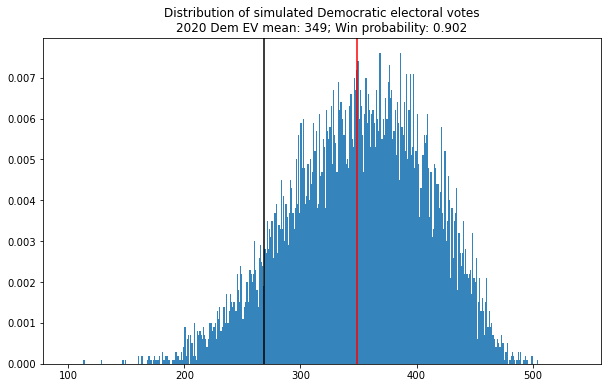

In [162]:
ax = plot_histogram(sim_results, 2020)
# https://stackoverflow.com/questions/19555525
ax.figure.savefig('histogram.png', bbox_inches='tight')

In [142]:
# TODO: Add in states that never tip it
tp_states = pd.DataFrame({'state':sim_results[2020]['tipping_point_states']})
tp_states['count'] = 1
tp_states = tp_states.groupby(by='state').agg({'count':'count'})
tp_states['tipping_prob'] = tp_states['count']/tp_states['count'].sum()
tp_states.sort_values(by='tipping_prob', ascending=False).head(25)

,count,tipping_prob
state,,
FL,1288,0.1288
TX,980,0.0980
PA,843,0.0843
MI,701,0.0701
OH,549,0.0549
NC,525,0.0525
VA,491,0.0491
GA,477,0.0477
MN,404,0.0404


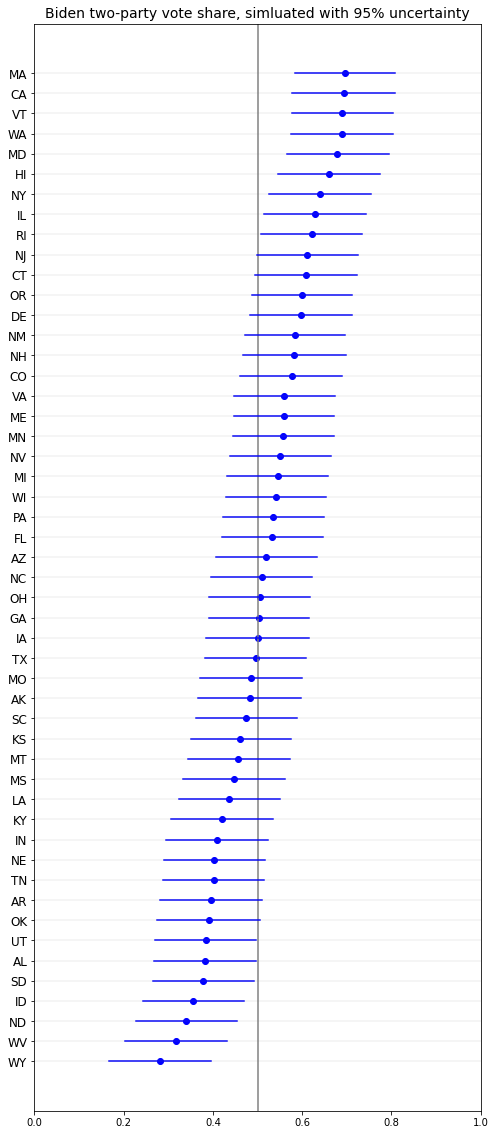

In [161]:
fig, ax = plt.subplots(figsize=(8,20))

dem_state_votes = sim_results[2020]['dem_state_votes']
dem_state_votes_sorted = dem_state_votes.mean().sort_values()[:-1]

plt.xlim(0,1)
plt.title('Biden two-party vote share, simluated with 95% uncertainty', fontsize = 14)
plt.yticks(np.arange(len(dem_state_votes_sorted)), dem_state_votes_sorted.index, fontsize = 12)
ax.axvline(0.5, color = 'gray')

plt.scatter(dem_state_votes_sorted, np.arange(len(dem_state_votes_sorted)), color = 'blue')
for i, state in enumerate(dem_state_votes_sorted.index):
    plt.plot([dem_state_votes[state].quantile(0.025), 
              dem_state_votes[state].quantile(0.975)],
              [i, i], color = 'blue')
    ax.axhline(i, color = 'gray', alpha = 0.1)
plt.savefig('voteshare.png', bbox_inches='tight')
plt.show()

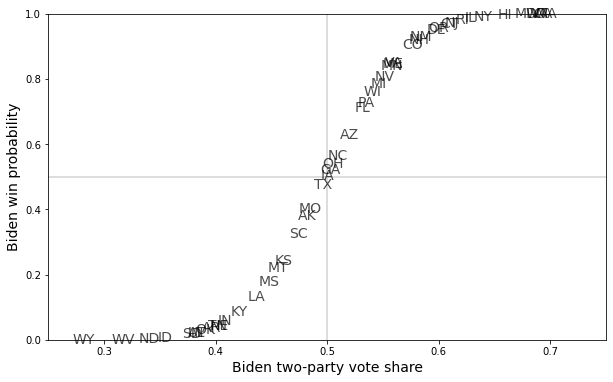

In [130]:
fig, ax = plt.subplots(figsize = (10,6))
plt.xlim(0.25, 0.75)
plt.xlabel('Biden two-party vote share', fontsize = 14)
plt.ylabel('Biden win probability', fontsize = 14)

dem_state_win_prob = sim_results[2020]['dem_state_wins'] / number_of_simulations
for state in state_mean.index:
    if state != 'DC':
        plt.text(sim_results[2020]['dem_state_votes'].mean()[state],
                 dem_state_win_prob[state],
                 state, ha = 'center', va = 'center', 
                 fontsize = 14, alpha = 0.7)
        
ax.axvline(0.5, color = 'lightgray');
ax.axhline(0.5, color = 'lightgray');

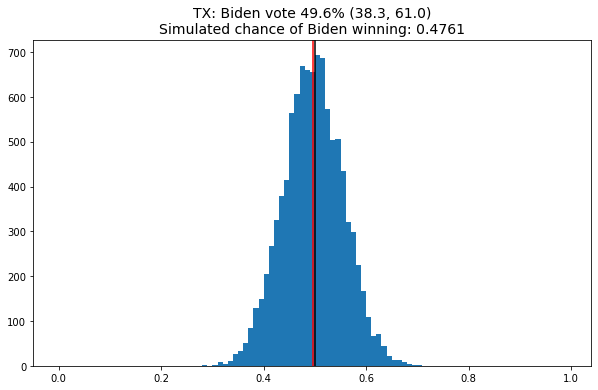

In [146]:
plot_state = 'TX' #AZ

biden_state_votes = sim_results[2020]['dem_state_votes']
fig, ax = plt.subplots(figsize=(10,6))
plt.hist(biden_state_votes[plot_state], bins = np.arange(0,1,0.01));
plt.title('%s: Biden vote %s%% (%s, %s)\nSimulated chance of Biden winning: %s'%(
        plot_state,
        np.round((100*biden_state_votes[plot_state].mean()),1),
        np.round((100*biden_state_votes[plot_state].quantile(0.025)),1),
        np.round((100*biden_state_votes[plot_state].quantile(0.975)),1),
        dem_state_win_prob[plot_state]),
    fontsize = 14)
plt.axvline(0.5, color = 'black');
plt.axvline(biden_state_votes[plot_state].mean(), color = 'red');

# Backtesting

Looking at how well this model would perform in 2008-2016 elections, then looking at how well it would perform **at this point in time (August)** for those elections.


In [132]:
prediction_dates = [
    pd.to_datetime('2008-11-4'),
    pd.to_datetime('2012-11-6'),
    pd.to_datetime('2016-11-8'),
    pd.to_datetime('2020-8-17')
]

backtest_results = {}
# Get mean polling data by state
for date in prediction_dates: 
    year = date.year
    start_date = date - DateOffset(months=2)
    end_date = date
    state_mean = prepare_polls(year, start_date, end_date, pres_df, polls_df, national_df)
    if year == 2008:
        ev = electoral_votes_2008
    else:
        ev = electoral_votes
    backtest_results[year] = run_simulation(
        number_of_simulations,
        year, 
        state_uncertainty_sd, 
        national_uncertainty_sd,
        state_mean,
        ev
    )

2008 States with polls: 52
National Democratic Swing from 2004 to 2008: 0.04113423627955087
2012 States with polls: 42
National Democratic Swing from 2008 to 2012: -0.022484893206616396
2016 States with polls: 51
National Democratic Swing from 2012 to 2016: -0.01611618867793796
2020 States with polls: 32
National Democratic Swing from 2016 to 2020: 0.038586176161272356


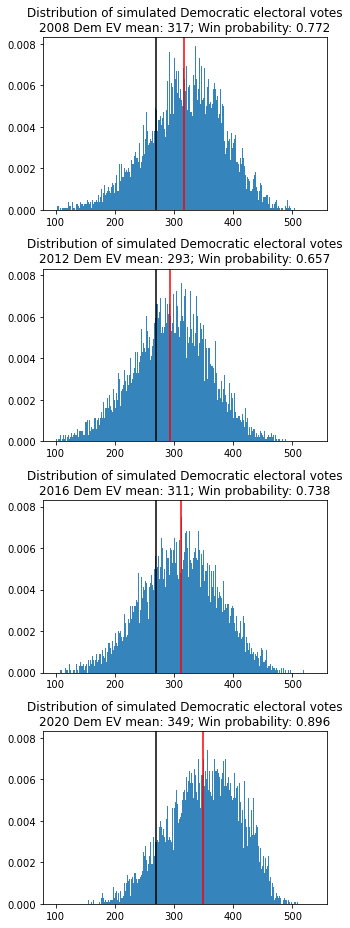

In [164]:
fig, axs = plt.subplots(4, 1, sharey=True, figsize=(5,13), facecolor='w')
for year, ax in zip([2008,2012,2016, 2020], axs.flat):
    plot_histogram(backtest_results, year, ax=ax)
fig.tight_layout()

In [134]:
estimated_ev = []
demvote_rmse = []
state_error = []

for year in [2008, 2012, 2016]:
    estimated_ev.append(int(np.mean(backtest_results[year]['dem_ev_sim']).round()))
    comparator = pres_df[pres_df.year == year]
    
    a = backtest_results[year]['dem_state_votes'].mean().T.to_frame(name='model_dem')
    b = pres_df[pres_df.year == year][['year', 'state', 'dem']].set_index('state')
    c = b.merge(a, left_index = True, right_index = True)
    c[['model_dem', 'dem']] = c[['model_dem', 'dem']]*100 # Convert to percentages
    c['demvote_error'] = c['model_dem'] - c['dem']
    demvote_rmse.append(np.sqrt((c['demvote_error']**2).mean()))
    state_error.append(c)

# 538 projection sources, election night
# https://web.archive.org/web/20081106113055/http://www.fivethirtyeight.com/
# https://web.archive.org/web/20121106233226/http://fivethirtyeight.blogs.nytimes.com/
# https://projects.fivethirtyeight.com/2016-election-forecast/
ec_df = pd.DataFrame.from_dict({
    'year': [2008, 2012, 2016],
    'estimate_ev': estimated_ev,
    'estimate_ev_538': [349, 313, 302],
    'actual_ev': [365, 332, 227],
    'demvote_rmse': demvote_rmse
})
ec_df['ev_error'] = ec_df['estimate_ev'] - ec_df['actual_ev']
ec_df['ev_error_538'] = ec_df['estimate_ev_538'] - ec_df['actual_ev']
ec_df = ec_df[['year', 'estimate_ev', 'actual_ev', 'ev_error', 'ev_error_538', 'demvote_rmse']]
ec_df

,year,estimate_ev,actual_ev,ev_error,ev_error_538,demvote_rmse
0,2008,317,365,-48,-16,3.085322
1,2012,294,332,-38,-19,2.327522
2,2016,311,227,84,75,3.510493


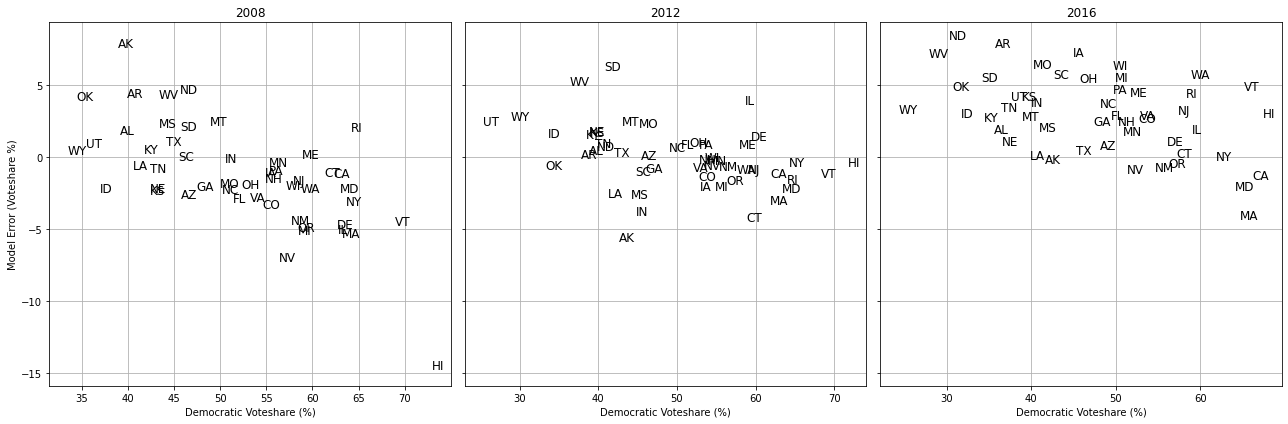

In [149]:
state_error_df = pd.concat(state_error, axis=0)
state_error_df.reset_index(drop=False, inplace=True)
state_error_df = state_error_df[state_error_df.state != 'DC']

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18,6), facecolor='w')

for year, ax in zip([2008,2012,2016], axs):
    temp_df = state_error_df[state_error_df.year == year]
    xvals = temp_df['dem']
    ax.set_title(str(year))
    temp_df.plot('dem', 'demvote_error', kind='scatter', ax=ax, marker='')
    ax.grid()
    ax.set_xlabel('Democratic Voteshare (%)')
    ax.set_ylabel('Model Error (Voteshare %)')
    for (x, y, text) in zip(xvals, temp_df['demvote_error'], temp_df['state']):
        ax.annotate(text, (x,y), fontsize=12)
fig.tight_layout()
plt.show()

In [136]:
# def background_with_norm(s):
#     cmap = matplotlib.cm.get_cmap('coolwarm')
#     if s.values.min() >= 0 or s.values.max() <= 0:
#         return ['background-color: {:s}'.format(matplotlib.colors.to_hex(c.flatten())) for c in cmap(s.values)]
#     else:
#         norm = matplotlib.colors.TwoSlopeNorm(vmin=s.values.min(), vcenter=0, vmax=s.values.max())    
#     return ['background-color: {:s}'.format(matplotlib.colors.to_hex(c.flatten())) for c in cmap(norm(s.values))]
# state_error_df = pd.concat(state_error, axis=1)
# #state_error_df = state_error_df.abs()
# state_error_df['mean_abs_error'] = state_error_df.abs().mean(axis=1)
# #state_error_df.reset_index(drop=False, inplace=True)
# state_error_df = state_error_df.sort_values(by='mean_abs_error', ascending=False)
# #cmap = sns.diverging_palette(18, 18, center='light', as_cmap=True) #s=75, l=50,
# state_error_df = state_error_df*100
# state_error_df.style.apply(background_with_norm)
# #state_error_df.style.background_gradient(cmap='coolwarm') #cmap='bwr'  .abs() cmap='coolwarm',
# # Maybe a plot would work better for this?

# Nowcast, historic forecast performance from August

This modeling approach relies on a current polling average, but doesn't forecast how the polls might change before November. Below I look at how this approach performs in August of previous years. Overall, it performs pretty similarly to the "election night" performance above. Although 2016 is actually more confident in a Clinton's win in  August vs. November (.808 vs. .738). And August is more uncertain about Obama's first 2008 win (.693 vs. .772). So the poll changes do matter for accuracy, and predicting how polls will change seems to be what adds all the complexity to the 538/Economist models.

In [137]:
today = pd.to_datetime('2020-08-17')
prediction_dates = [
    today - DateOffset(years = 12),
    today - DateOffset(years = 8),
    today - DateOffset(years = 4),
    today
]

nowcast_results = {}
for date in prediction_dates: 
    year = date.year
    start_date = date - DateOffset(months=2)
    end_date = date
    state_mean = prepare_polls(year, start_date, end_date, pres_df, polls_df, national_df)
    if year == 2008:
        ev = electoral_votes_2008
    else:
        ev = electoral_votes
    nowcast_results[year] = run_simulation(
        number_of_simulations,
        year, 
        state_uncertainty_sd, 
        national_uncertainty_sd,
        state_mean,
        ev
    )

2008 States with polls: 42
National Democratic Swing from 2004 to 2008: 0.039525382659921504
2012 States with polls: 32
National Democratic Swing from 2008 to 2012: -0.020192485671858162
2016 States with polls: 33
National Democratic Swing from 2012 to 2016: -0.01608025324516693
2020 States with polls: 32
National Democratic Swing from 2016 to 2020: 0.038586176161272356


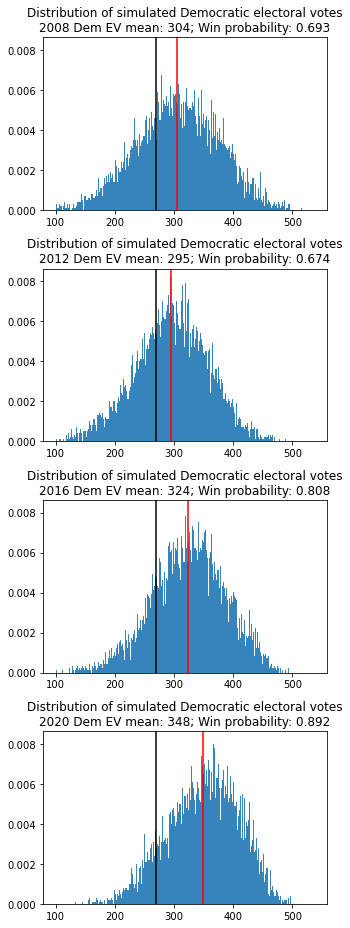

In [138]:
fig, axs = plt.subplots(4, 1, sharey=True, figsize=(5,13))  
for year, ax in zip([2008,2012,2016, 2020], axs.flat):
    plot_histogram(nowcast_results, year, ax=ax)
fig.tight_layout()

In [139]:
estimated_ev = []
demvote_rmse = []
state_error = []

for year in [2008, 2012, 2016]:
    estimated_ev.append(int(np.mean(nowcast_results[year]['dem_ev_sim']).round()))
    comparator = pres_df[pres_df.year == year]
    
    a = nowcast_results[year]['dem_state_votes'].mean().T.to_frame(name='model_dem')
    b = pres_df[pres_df.year == year][['year', 'state', 'dem']].set_index('state')
    c = b.merge(a, left_index = True, right_index = True)
    c[['model_dem', 'dem']] = c[['model_dem', 'dem']]*100 # Convert to percentages
    c['demvote_error'] = c['model_dem'] - c['dem']
    demvote_rmse.append(np.sqrt((c['demvote_error']**2).mean()))
    state_error.append(c)
        
ec_df = pd.DataFrame.from_dict({
    'year': [2008, 2012, 2016],
    'estimate_ev': estimated_ev,
    'estimate_ev_538': [349, 313, 302],
    'actual_ev': [365, 332, 227],
    'demvote_rmse': demvote_rmse
})
ec_df['ev_error'] = ec_df['estimate_ev'] - ec_df['actual_ev']
ec_df['ev_error_538'] = ec_df['estimate_ev_538'] - ec_df['actual_ev']
ec_df = ec_df[['year', 'estimate_ev', 'actual_ev', 'ev_error', 'ev_error_538', 'demvote_rmse']]
ec_df

,year,estimate_ev,actual_ev,ev_error,ev_error_538,demvote_rmse
0,2008,305,365,-60,-16,3.764637
1,2012,295,332,-37,-19,2.193241
2,2016,324,227,97,75,3.829940


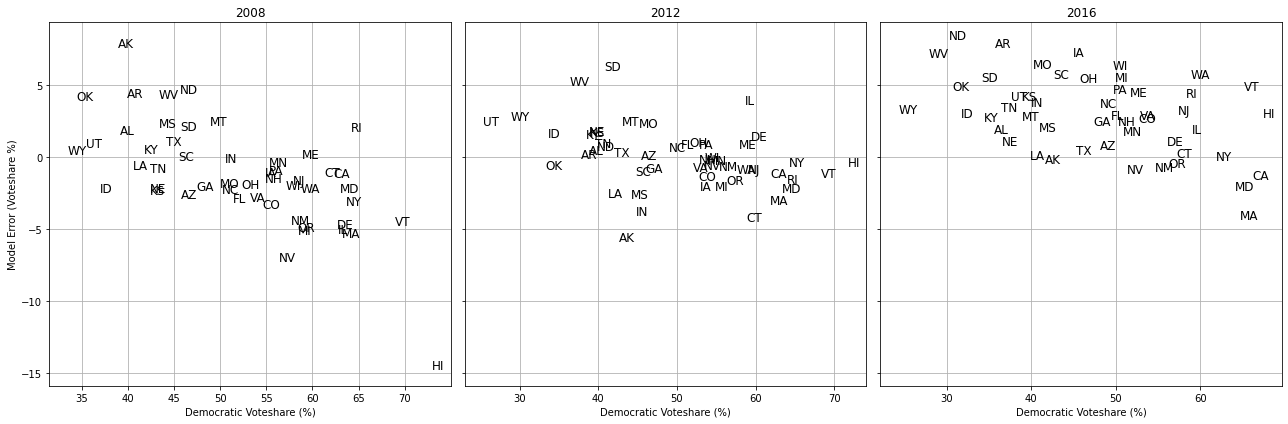

In [140]:
state_error_df = pd.concat(state_error, axis=0)
state_error_df.reset_index(drop=False, inplace=True)
state_error_df = state_error_df[state_error_df.state != 'DC']

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18,6))
for year, ax in zip([2008,2012,2016], axs):
    temp_df = state_error_df[state_error_df.year == year]
    xvals = temp_df['dem']
    ax.set_title(str(year))
    temp_df.plot('dem', 'demvote_error', kind='scatter', ax=ax, marker='')
    ax.grid()
    ax.set_xlabel('Democratic Voteshare (%)')
    ax.set_ylabel('Model Error (Voteshare %)')
    for (x, y, text) in zip(xvals, temp_df['demvote_error'], temp_df['state']):
        ax.annotate(text, (x,y), fontsize=12)
fig.tight_layout()
plt.show()